### 추론기반 기법
- 통계기반 기법 : 동시발생 행렬, PPMI, SVD(특잇값 분해) 사용 / 학습 데이터를 한꺼번에 처리 / 대용량 데이터 처리에 부적합
- 추론기반 기법 : word2vec 사용 / 학습 데이터의 일부를 순차적 학습 / 대용량 데이터 처리 적합, GPU 활용 병렬처리로 학습 속도 개선 가능

In [1]:
#완전연결계층에 의한 변환

import numpy as np

c = np.array([[1,0,0,0,0,0,0]]) #입력층
W = np.random.randn(7,3) #가중치
h = np.matmul(c,W)
print(h)

[[ 0.82216235  1.19111852 -0.0130895 ]]


In [6]:
# MatMul(행렬곱) 계층 ver

import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul

c = np.array([[1,0,0,0,0,0,0]]) #입력층
W = np.random.randn(7,3) #가중치 #평균 0, 표준편차 1의 가우시안 표준정규분포 난수를 matrix array(m,n)으로 생성성
layer = MatMul(W)
h = layer.forward(c) #순전파 수행 = 신경망에서 입력 데이터가 입력층을 통과하여 순차적으로 각 레이어를 거쳐 출력층까지 전달
print(h)

[[-0.4153813  -0.18569358  0.98859295]]


#### 모델 구축(CBOW)
- CBOW(continuos bag-of-words) : word2vec에서 사용되는 신경망, 맥락(주변 단어 = 입력)으로부터 타겟(중앙 단어 = 출력)을 추측

In [7]:
#cbow 추론 처리(점수를 구하는 처리)

import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul

#샘플 맥락 데이터(입력층 2개 = 고려할 단어 수 2개)
c0 = np.array([[1,0,0,0,0,0,0]])
c1 = np.array([[0,0,1,0,0,0,0]])

#가중치 초기화
W_in = np.random.randn(7,3)
W_out = np.random.randn(3,7)

#계층 생성
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in) #두 입력값을 함께 고려하여 하나의 은닉층 h를 만들기 위해서는, 두 입력값을 처리하는 과정에서 동일한 단어 표현(가중치)을 공유해야 함
out_layer = MatMul(W_out)

#순전파
h0 = in_layer0.forward(c0) # 중간 데이터 계산
h1 = in_layer1.forward(c1)
h = 0.5 * (h0+h1) #은닉층
s = out_layer.forward(h) #점수 계산

print(s)

[[-2.42249949 -1.82801057  0.03054774 -0.3114692   0.46248026  0.72891645
  -0.46695901]]


In [8]:
# 전처리(벡터화)

import sys
sys.path.append('..')
from common.util import preprocess

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [9]:
#맥락, 타깃 생성 함수 정의

def create_contexts_target(corpus, window_size=1):
    target = corpus[window_size:-window_size]
    contexts = []

    for idx in range(window_size, len(corpus) - window_size):
        cs = [] # 각 단어의 맥락을 담을 리스트
        for t in range(-window_size, window_size + 1):
            if t ==0: 
                continue # 타겟 단어는 맥락에 포함하지 않음
            cs.append(corpus[idx+t]) # 맥락에 해당하는 단어를 추가
        contexts.append(cs) # 해당 단어의 맥락 리스트를 전체 맥락에 추가

    return np.array(contexts), np.arrary(target)


In [10]:
#원핫 표현으로 변환

import sys
sys.path.append('..')
from common.util import preprocess, create_contexts_target, convert_one_hot

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

contexts, target = create_contexts_target(corpus, window_size=1)

vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

In [ ]:
# CBOW 모델 구현
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss

class SimpleCBOW:
    def __init__(self, vocab_size,hidden_size): #hidden_size = 은닉층의 뉴런 수
        V,H = vocab_size, hidden_size

        #가중치 초기화
        W_in = 0.01*np.random.randn(V,H).astype('f') # f = 32비트 부동소수점 수
        W_out = 0.01*np.random.randn(H,V).astype('f')

        #계층 생성
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        #모든 가중치와 기울기를 리스트에 모으기
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        #인스턴스 변수에 단어의 분산 표현을 저장
        self.word_vecs = W_in

In [ ]:
# foward 메서드 구현(입력 -> 출력)

def forward(self, contexts, target):
    h0 = self.in_layer0.forward(contexts[:,0])
    h1 = self.in_layer0.forward(contexts[:,1])
    h = (h0 + h1) * 0.5
    score = self.out_layer.forward(h)
    loss = self.loss_layer.forward(score, target)
    return loss


In [ ]:
# backward 메서드 구현(역전파)

def backward(self, dout=1):
    ds = self.loss_layer.backward(dout)
    da = self.out_layer.backward(ds)
    da *= 0.5
    self.in_layer1.backward(da)
    self.in_layer0.backward(da)
    return None


In [3]:
#CBOW 학습 코드(실제 적용)

import sys
sys.path.append('..')
from common.trainer import Trainer
from common.optimizer import Adam
from simple_cbow import SimpleCBOW
from common.util import preprocess, create_contexts_target, convert_one_hot

window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)

#cbow학습 데이터셋 생성
contexts, target = create_contexts_target(corpus, window_size)

#input에 맞는 원핫 변환
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

#모델 초기화
model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

#학습
trainer.fit(contexts, target, max_epoch, batch_size)

| 에폭 1 |  반복 1 / 1 | 시간 0[s] | 손실 1.79
| 에폭 2 |  반복 1 / 1 | 시간 0[s] | 손실 1.79
| 에폭 3 |  반복 1 / 1 | 시간 0[s] | 손실 1.79
| 에폭 4 |  반복 1 / 1 | 시간 0[s] | 손실 1.79
| 에폭 5 |  반복 1 / 1 | 시간 0[s] | 손실 1.79
| 에폭 6 |  반복 1 / 1 | 시간 0[s] | 손실 1.79
| 에폭 7 |  반복 1 / 1 | 시간 0[s] | 손실 1.79
| 에폭 8 |  반복 1 / 1 | 시간 0[s] | 손실 1.79
| 에폭 9 |  반복 1 / 1 | 시간 0[s] | 손실 1.79
| 에폭 10 |  반복 1 / 1 | 시간 0[s] | 손실 1.79
| 에폭 11 |  반복 1 / 1 | 시간 0[s] | 손실 1.79
| 에폭 12 |  반복 1 / 1 | 시간 0[s] | 손실 1.79
| 에폭 13 |  반복 1 / 1 | 시간 0[s] | 손실 1.79
| 에폭 14 |  반복 1 / 1 | 시간 0[s] | 손실 1.79
| 에폭 15 |  반복 1 / 1 | 시간 0[s] | 손실 1.79
| 에폭 16 |  반복 1 / 1 | 시간 0[s] | 손실 1.79
| 에폭 17 |  반복 1 / 1 | 시간 0[s] | 손실 1.79
| 에폭 18 |  반복 1 / 1 | 시간 0[s] | 손실 1.79
| 에폭 19 |  반복 1 / 1 | 시간 0[s] | 손실 1.79
| 에폭 20 |  반복 1 / 1 | 시간 0[s] | 손실 1.79
| 에폭 21 |  반복 1 / 1 | 시간 0[s] | 손실 1.79
| 에폭 22 |  반복 1 / 1 | 시간 0[s] | 손실 1.79
| 에폭 23 |  반복 1 / 1 | 시간 0[s] | 손실 1.79
| 에폭 24 |  반복 1 / 1 | 시간 0[s] | 손실 1.79
| 에폭 25 |  반복 1 / 1 | 시간 0[s] | 손실 1.79
| 에폭 26 |

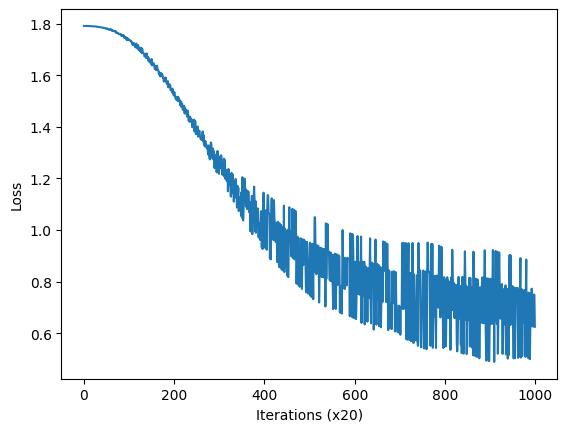

In [5]:
trainer.plot()

In [6]:
word_vecs1 = model.word_vecs1
for word_id, word in id_to_word.items():
    print(word, word_vecs1[word_id])

you [-0.6744617   0.781303    0.7777818   0.97495943 -0.79776704]
say [ 0.8087416  -0.80591094 -0.8077208   0.9475015   0.781043  ]
goodbye [-0.8056866   0.7778914   0.71693385  0.3847293  -0.7097295 ]
and [ 0.8379376  -0.78718    -0.80064523  0.92742527  0.8036502 ]
i [-0.805318    0.78612596  0.7339185   0.41173276 -0.7192084 ]
hello [-0.678485    0.75490385  0.7557753   0.9770126  -0.8091272 ]


In [7]:
word_vecs2 = model.word_vecs2
for word_id, word in id_to_word.items():
    print(word, word_vecs2[word_id])

you [-0.05756993 -0.13159564 -0.27393156 -1.0724506   0.2141883 ]
say [-0.6859777   0.7190735   0.7374923   0.7306688  -0.75432557]
goodbye [ 0.6860752  -0.69627833 -0.7085815   0.3371403   0.70345443]
and [-0.68849206  0.610126    0.56795704 -0.10893106 -0.54042876]
i [ 0.6667094  -0.6682107  -0.6908468   0.31429824  0.68886006]
hello [-0.0605721  -0.14389257 -0.24946873 -1.0665276   0.2278089 ]
